# Reproducing JPM’s US Rates Strategy RV Trade Idea 
## Note - `Treasuries: The first cut is the deepest` (September 20th 2024)
## `91:100 3.125% Nov-41/ 2% Nov-41 flattener`

```
Turning to relative value, we’ve noticed that originally issued 20-year bonds maturing in late-2041 and early-2042 have cheapened relative to our par curve, whereas originally issued 30-year bonds with similar maturities have outperformed. Clearly, the recent steepening of the Treasury curve supports wider yield spreads between higher-coupon OI 30s, and lower-coupon OI 20s with the same maturity, given significant duration differences. However, this dynamic is not explained by duration profiles: Figure 20 displays the securities in the 2040–2043 basket, sorted by modified duration and shows that late-41/ early-42 OI 30s appear rich relative to other securities with similar duration. In particular, the 3.125% Nov-41/ 2% Nov-41 curve appears 5.0bp too steep relative to the shape of the 15s/20s Treasury par curve (Figure 21). Hence, we recommend initiating 91:100 weighted 3.125% Nov-41/ 2% Nov-41 flatteners (see Trade recommendations).
```

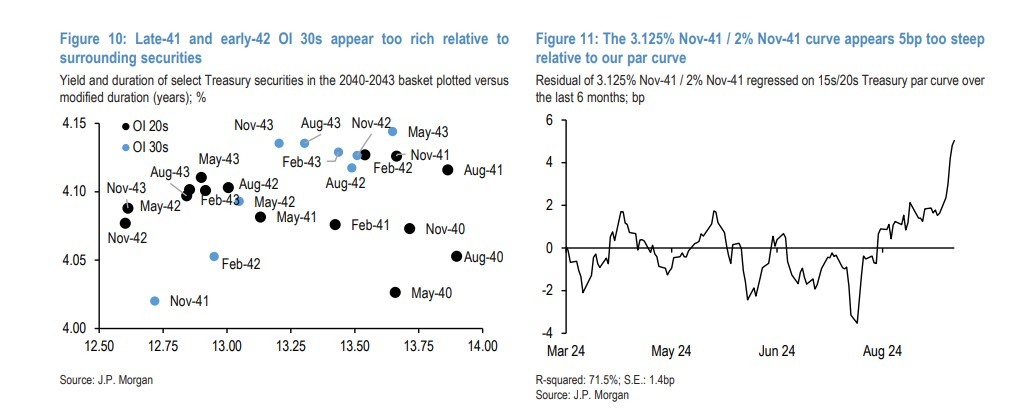

In [1]:
import sys
sys.path.append("../")

In [24]:
from CurvyCUSIPs.CurveDataFetcher import CurveDataFetcher
from CurvyCUSIPs.CurveInterpolator import GeneralCurveInterpolator
from CurvyCUSIPs.USTs import USTs

from CurvyCUSIPs.utils.ust_viz import plot_usts
from CurvyCUSIPs.HedgeHog import dv01_neutral_curve_hegde_ratio, beta_estimates
from CurvyCUSIPs.utils.pca_utils import calc_pca_loadings_matrix
from CurvyCUSIPs.utils.rv_utils import cusip_spread_rv_regression
from CurvyCUSIPs.utils.ust_viz import plot_usts
from CurvyCUSIPs.models.calibrate import calibrate_mles_ols, calibrate_nss_ols

import pandas as pd
import scipy.interpolate
from datetime import datetime
from typing import Dict, List

import tqdm
import os
from dotenv import dotenv_values
env_path = os.path.join(os.getcwd(), "../.env")
config = dotenv_values(env_path)

import nest_asyncio
nest_asyncio.apply()

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
curve_data_fetcher = CurveDataFetcher(fred_api_key=config["FRED_API_KEY"])

In [9]:
usts = USTs(
    cusip_set_db_path=r"..\db\ust_cusip_set",
    cusip_timeseries_db_path=r"..\db\ust_cusip_timeseries",
    ct_eod_db_path=r"..\db\ust_eod_ct_yields",
    curve_data_fetcher=curve_data_fetcher,
)

In [10]:
as_of_date = datetime(2024, 9, 20)

curve_set_df = usts.fetch_historical_curve_sets(
    start_date=as_of_date,
    end_date=as_of_date,
    fetch_soma_holdings=True,
    fetch_stripping_data=True,
    calc_free_float=True,
)[as_of_date]

curve_set_df

AGGREGATING CURVE SET DFs: 100%|██████████| 1/1 [00:00<00:00,  6.52it/s]


,cusip,security_type,auction_date,issue_date,maturity_date,price_per100,allocation_pctage,avg_med_yield,bid_to_cover_ratio,comp_accepted,comp_tendered,corpus_cusip,tint_cusip_1,currently_outstanding,direct_bidder_accepted,direct_bidder_tendered,est_pub_held_mat_by_type_amt,fima_included,fima_noncomp_accepted,fima_noncomp_tendered,high_discnt_rate,high_investment_rate,high_price,high_yield,indirect_bidder_accepted,indirect_bidder_tendered,int_rate,low_investment_rate,low_price,low_discnt_margin,low_yield,max_comp_award,max_noncomp_award,noncomp_accepted,noncomp_tenders_accepted,offering_amt,security_term,original_security_term,security_term_week_year,primary_dealer_accepted,primary_dealer_tendered,reopening,total_accepted,total_tendered,treas_retail_accepted,treas_retail_tenders_accepted,ust_label,cusip_right,security_type_right,security_term_right,original_security_term_right,auction_date_right,issue_date_right,maturity_date_right,int_rate_right,high_investment_rate_right,bid_price,offer_price,mid_price,eod_price,bid_yield,offer_yield,mid_yield,eod_yield,asOfDate,parValue,percentOutstanding,est_outstanding_amt,corpus_cusip_right,outstanding_amt,portion_unstripped_amt,portion_stripped_amt,reconstituted_amt,time_to_maturity,rank,free_float
0,912797LJ4,Bill,2024-08-22,2024-08-27,2024-09-24,99.592444,60.380000,null,2.670000,88693115000,247747290000,null,null,145470000000.000000,6400000000,18150000000,224986000000,Yes,76000000,76000000,5.240000,5.335,99.592444,null,46920090000,55512290000,NaN,null,null,null,null,33250000000,10000000,6231663900,Yes,95000000000,4-Week,17-Week,4-Week,35373025000,174085000000,Yes,95261691200,254315866200,5060934400,Yes,5.335% Sep-24,912797LJ4,Bill,4-Week,17-Week,2024-08-22,2024-08-27,2024-09-24,NaN,5.335,99.919667,NaN,NaN,99.934861,28.943131,NaN,NaN,23.465325,2024-09-18,7.426366e+08,0.003085,2.407091e+14,None,NaN,NaN,0.000000e+00,NaN,0.010959,16,2.407083e+08
1,912797KM8,Bill,2024-06-24,2024-06-27,2024-09-26,98.676708,13.880000,null,2.850000,67379297500,196583369500,null,null,70471000000.000000,6587380000,15650000000,215996000000,Yes,25000000,25000000,5.235000,5.379,98.676708,null,38615447500,50531369500,NaN,null,null,null,null,24500000000,10000000,2596317100,Yes,70000000000,13-Week,26-Week,13-Week,22176470000,130402000000,Yes,71421342600,200625414600,1356495500,Yes,5.379% Sep-24,912797KM8,Bill,13-Week,26-Week,2024-06-24,2024-06-27,2024-09-26,NaN,5.379,99.894667,99.895333,99.895000,99.909972,12.653288,12.573200,12.613244,10.813095,2024-09-18,1.894065e+09,0.008733,2.168860e+14,None,NaN,NaN,0.000000e+00,NaN,0.016438,18,2.168841e+08
2,912797LK1,Bill,2024-08-29,2024-09-03,2024-10-01,99.597889,94.310000,null,2.830000,78643810000,234067665000,null,null,145506000000.000000,3500000000,12700000000,229996000000,Yes,0,0,5.170000,5.263,99.597889,null,51807610000,61617665000,NaN,null,null,null,null,29750000000,10000000,6356471700,Yes,85000000000,4-Week,17-Week,4-Week,23336200000,159750000000,Yes,85256580900,240680435900,5129313300,Yes,5.263% Oct-24,912797LK1,Bill,4-Week,17-Week,2024-08-29,2024-09-03,2024-10-01,NaN,5.263,99.827750,99.828472,99.828111,99.842333,7.764625,7.732023,7.748324,7.106219,2024-09-18,7.639260e+08,0.003311,2.307445e+14,None,NaN,NaN,0.000000e+00,NaN,0.030137,15,2.307438e+08
3,912797GW1,Bill,2024-07-01,2024-07-05,2024-10-03,98.690000,47.450000,null,2.760000,70755250400,199262187900,null,null,121895000000.000000,3147450000,12000000000,213003000000,Yes,15000000,15000000,5.240000,5.383,98.690000,null,38379010400,48615187900,NaN,null,null,null,null,25550000000,10000000,2231435200,Yes,73000000000,13-Week,52-Week,13-Week,29228790000,138647000000,Yes,77506665100,206013602600,1187173000,Yes,5.383% Oct-24,912797GW1,Bill,13-Week,52-Week,2024-07-01,2024-07-05,2024-10-03,NaN,5.383,99.801250,99.802292,99.801771,99.816056,7.169249,7.131588,7.150418,6.634187,2024-09-18,1.241331e+10,0.045238,2.743999e+14,None,NaN,NaN,0.000000e+00,NaN,0.035616,12,2.743875e+08
4,912797LS4,Bill,2024-09-05,2024-09-10,2024-10-08,99.60

## Build Par Curve Model

In [14]:
def liquidity_premium_curve_set_filter(curve_set_df: pd.DataFrame):
    # remove OTRs, olds, double olds, triple olds
    curve_set_filtered_df = curve_set_df[
        (curve_set_df["rank"] != 0) & (curve_set_df["rank"] != 1) & (curve_set_df["rank"] != 2) & (curve_set_df["rank"] != 3)
    ]

    # remove TBills
    curve_set_filtered_df = curve_set_filtered_df[curve_set_filtered_df["security_type"] != "Bill"]

    # remove low free float bonds (< $5bn)
    curve_set_filtered_df = curve_set_filtered_df[curve_set_filtered_df["free_float"] > 5000]

    # filter out bonds very close to maturity
    curve_set_filtered_df = curve_set_filtered_df[curve_set_filtered_df["time_to_maturity"] > 30 / 360]

    # remove CTDs
    curve_set_filtered_df = curve_set_filtered_df[
        ~curve_set_filtered_df["cusip"].isin(
            [
                usts.cme_ust_label_to_cusip("4 5/8 09/15/2026")["cusip"],  # TU
                usts.cme_ust_label_to_cusip("4 1/8 09/30/2027")["cusip"],  # Z3N
                usts.cme_ust_label_to_cusip("4 1/4 02/28/2029")["cusip"],  # FV
                usts.cme_ust_label_to_cusip("4 1/4 06/30/2031")["cusip"],  # TY
                usts.cme_ust_label_to_cusip("4 3/8 05/15/2034")["cusip"],  # TN
                usts.cme_ust_label_to_cusip("4 5/8 02/15/2040")["cusip"],  # US
                usts.cme_ust_label_to_cusip("4 1/2 02/15/2044")["cusip"],  # TWE
                usts.cme_ust_label_to_cusip("4 3/4 11/15/2053")["cusip"],  # UL
            ]
        )
    ] 

    curve_set_filtered_df = curve_set_filtered_df.sort_values(by=["time_to_maturity"])

    return curve_set_filtered_df


def no_filter(curve_set_df: pd.DataFrame):
    return curve_set_df

In [15]:
# filter and fit bspline w/ knots are liquidity points
curve_set_filtered_df = liquidity_premium_curve_set_filter(curve_set_df=curve_set_df)

filtered_fitted_interpolator = GeneralCurveInterpolator(
    x=curve_set_filtered_df["time_to_maturity"].to_numpy(),
    y=curve_set_filtered_df["eod_yield"].to_numpy(),
)

fitted_bspline = filtered_fitted_interpolator.b_spline_with_knots_interpolation(
    knots=[0.5, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 15, 20, 25],
    k=3,
    return_func=True,
)

nss_func, status_nss, _ = calibrate_nss_ols(
    curve_set_filtered_df["time_to_maturity"].to_numpy(),
    curve_set_filtered_df["eod_yield"].to_numpy(),
)
assert status_nss

mles_func, status_mles = calibrate_mles_ols(
    curve_set_filtered_df["time_to_maturity"].to_numpy(),
    curve_set_filtered_df["eod_yield"].to_numpy(),
    overnight_rate=5.31,
    N=9,
)

In [20]:
plot_usts(
    curve_set_df=curve_set_df,
    ttm_col="time_to_maturity",
    ytm_col="eod_yield",
    hover_data=[
        "issue_date",
        "maturity_date",
        "cusip",
        "original_security_term",
        "ust_label",
        "eod_price",
        "free_float",
    ],
    ust_labels_highlighter=[
        ("3.125% Nov-41", "red"), ("2.000% Nov-41", "blue"), 
    ],
    zero_curves=[(fitted_bspline, "BSpline k=3 - Zero Filtered Fit"), (nss_func, "Nelson Siegel Svensson"), (mles_func, "Merrill Lynch Exponential Spline")],
    par_curves=[(fitted_bspline, "BSpline k=3 - Par FF",)],
    impl_spot_n_yr_fwd_curves=[(fitted_bspline, 1, "Impl Spots, 1y Fwd")],
    impl_par_n_yr_fwd_curves=[(fitted_bspline, 1, "Impl Par, 1y Fwd")],
    title=f"US Treasury Market: All Active CUSIPS: {as_of_date}",

)

c:\Users\chris\Project Bond King\Curvy-CUSIPs\notebooks\..\CurvyCUSIPs\models\MLESM.py:47: RuntimeWarning:

divide by zero encountered in divide



## Fetching historical curve sets to regress 3.125% Nov-41/ 2% Nov-41 flattener vs our fitted model over time

In [22]:
start_date = datetime(2024, 3, 1)
end_date = datetime(2024, 9, 20)

curve_sets_dict_df, fitted_curves_dict = usts.fetch_historical_curve_sets(
    start_date=start_date,
    end_date=end_date,
    fetch_soma_holdings=True,
    fetch_stripping_data=True,
    calc_free_float=True,
    fitted_curves=[
        ("LPF", "eod_yield", liquidity_premium_curve_set_filter),
    ],
)

AGGREGATING CURVE SET DFs: 100%|██████████| 142/142 [00:15<00:00,  9.16it/s]


### Better data structure to fetch specific CUSIP timeseries data
- Comparing different curve building methods on different filtering strats 

In [27]:
cusip_timeseries: Dict[str, List[Dict[str, str | float | int]]] = {}
fitted_cubic_spline_timeseries: Dict[datetime, scipy.interpolate.CubicSpline] = {}
fitted_bspline_timeseries: Dict[datetime, scipy.interpolate.BSpline] = {}
fitted_smooth_spline_timeseries: Dict[datetime, scipy.interpolate.SmoothBivariateSpline] = {}

for dt in tqdm.tqdm(curve_sets_dict_df.keys(), desc="Main Loop"):
    fitted_cubic_spline = fitted_curves_dict[dt]["LPF"].b_spline_with_knots_interpolation(
        knots=[0.5, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 15, 20, 25],
        k=3,
        return_func=True,
    )
    fitted_bspline = fitted_curves_dict[dt]["LPF"].b_spline_with_knots_interpolation(
        knots=[0.5, 1, 2, 3, 4, 5, 7, 8, 9, 10, 15, 20, 25], k=5, return_func=True
    )
    fitted_smooth_spline = fitted_curves_dict[dt]["LPF"].b_spline_with_knots_interpolation(
        knots=[0.5, 1, 2, 3, 5, 7, 10, 20], k=4, return_func=True
    )

    fitted_cubic_spline_timeseries[dt] = fitted_cubic_spline
    fitted_bspline_timeseries[dt] = fitted_bspline
    fitted_smooth_spline_timeseries[dt] = fitted_smooth_spline 

    curr_curve_set_df = curve_sets_dict_df[dt]
    curr_curve_set_df["lpf_cubic_spline_spread"] = curr_curve_set_df["eod_yield"] - fitted_cubic_spline(curr_curve_set_df["time_to_maturity"])
    curr_curve_set_df["lpf_bspline_spread"] = curr_curve_set_df["eod_yield"] - fitted_bspline(curr_curve_set_df["time_to_maturity"])
    curr_curve_set_df["lpf_smooth_spline_spread"] = curr_curve_set_df["eod_yield"] - fitted_smooth_spline(curr_curve_set_df["time_to_maturity"])
    
    for _, row in curr_curve_set_df.iterrows():
        if row["cusip"] not in cusip_timeseries:
            cusip_timeseries[row["cusip"]] = []

        payload = {
            "Date": dt,
            "cusip": row["cusip"],
            "eod_yield": row["eod_yield"],
            "eod_price": row["eod_price"],
            "lpf_cubic_spline_spread": row["lpf_cubic_spline_spread"],
            "lpf_bspline_spread": row["lpf_bspline_spread"],
            "lpf_smooth_spline_spread": row["lpf_smooth_spline_spread"],
            "free_float": row["free_float"],
            "est_outstanding_amount": row["est_outstanding_amt"],
            "soma_holdings": row["parValue"],
            "soma_holdings_percent_outstanding": row["percentOutstanding"],
            "stripped_amount": row["portion_stripped_amt"],
            "reconstituted_amount": row["reconstituted_amt"],
            "lpf_cubic_spline": fitted_cubic_spline,
            "lpf_bspline": fitted_bspline,
            "lpf_smooth_spline": fitted_smooth_spline,
        }
        
        cusip_timeseries[row["cusip"]].append(payload)

Main Loop: 100%|██████████| 142/142 [00:04<00:00, 29.61it/s]


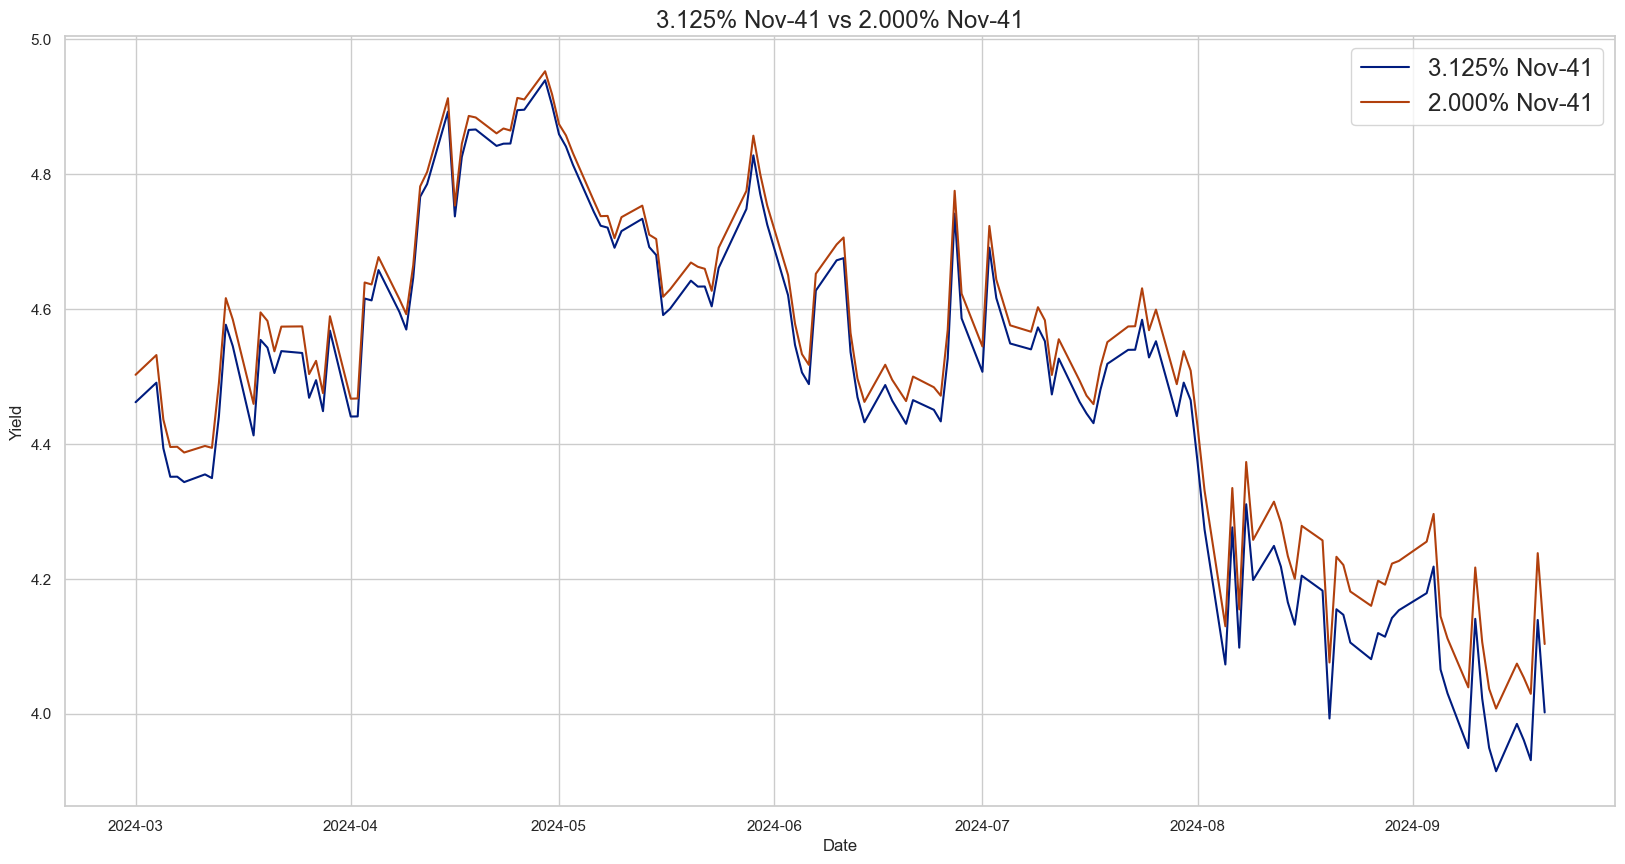

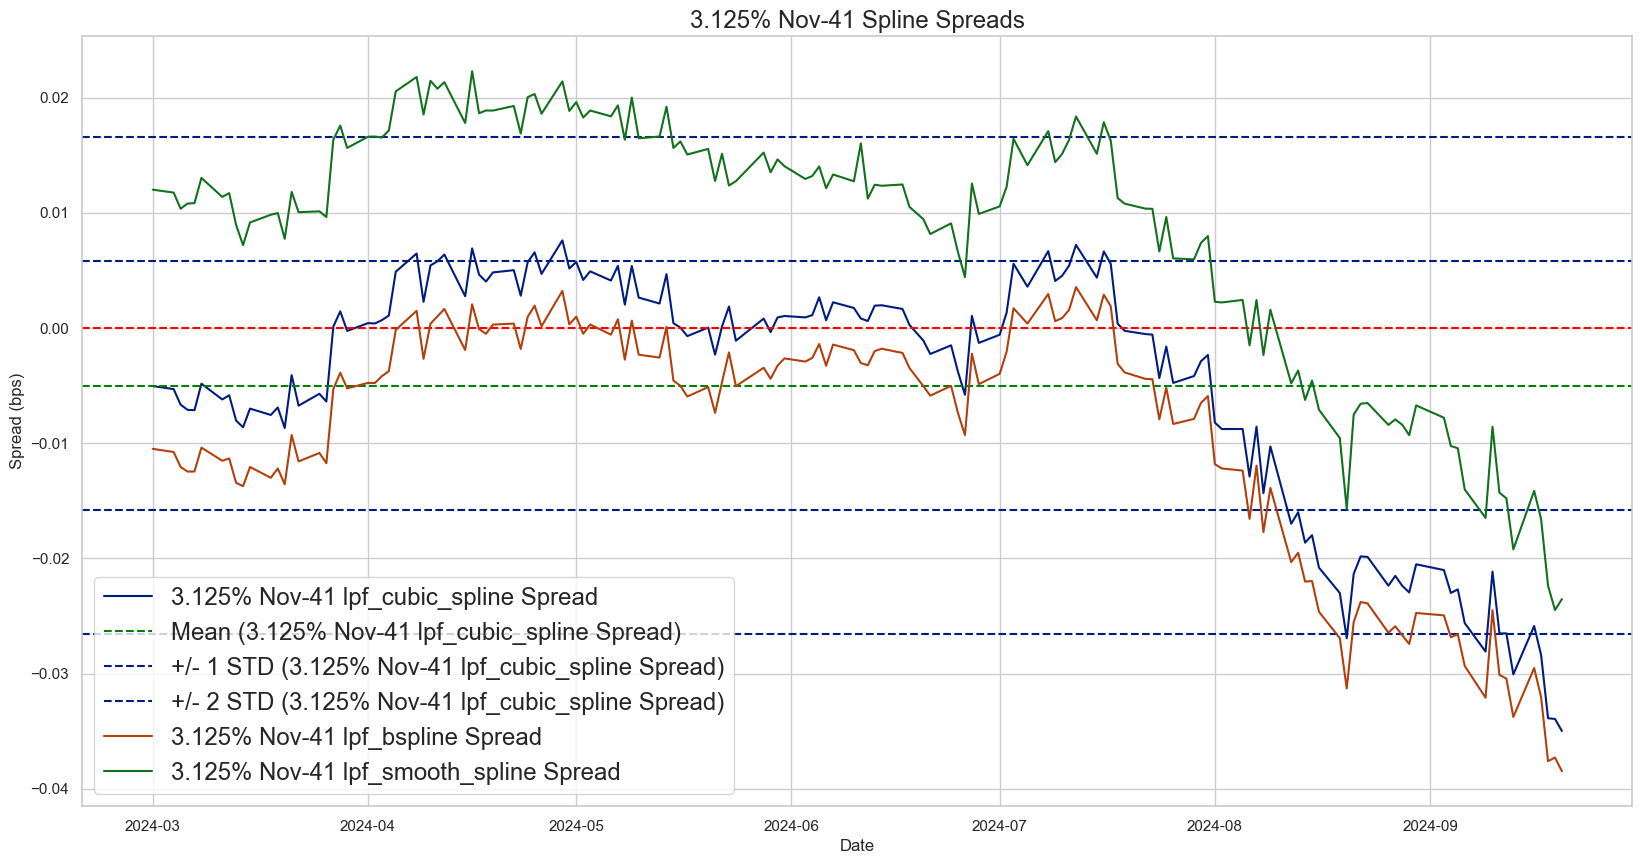

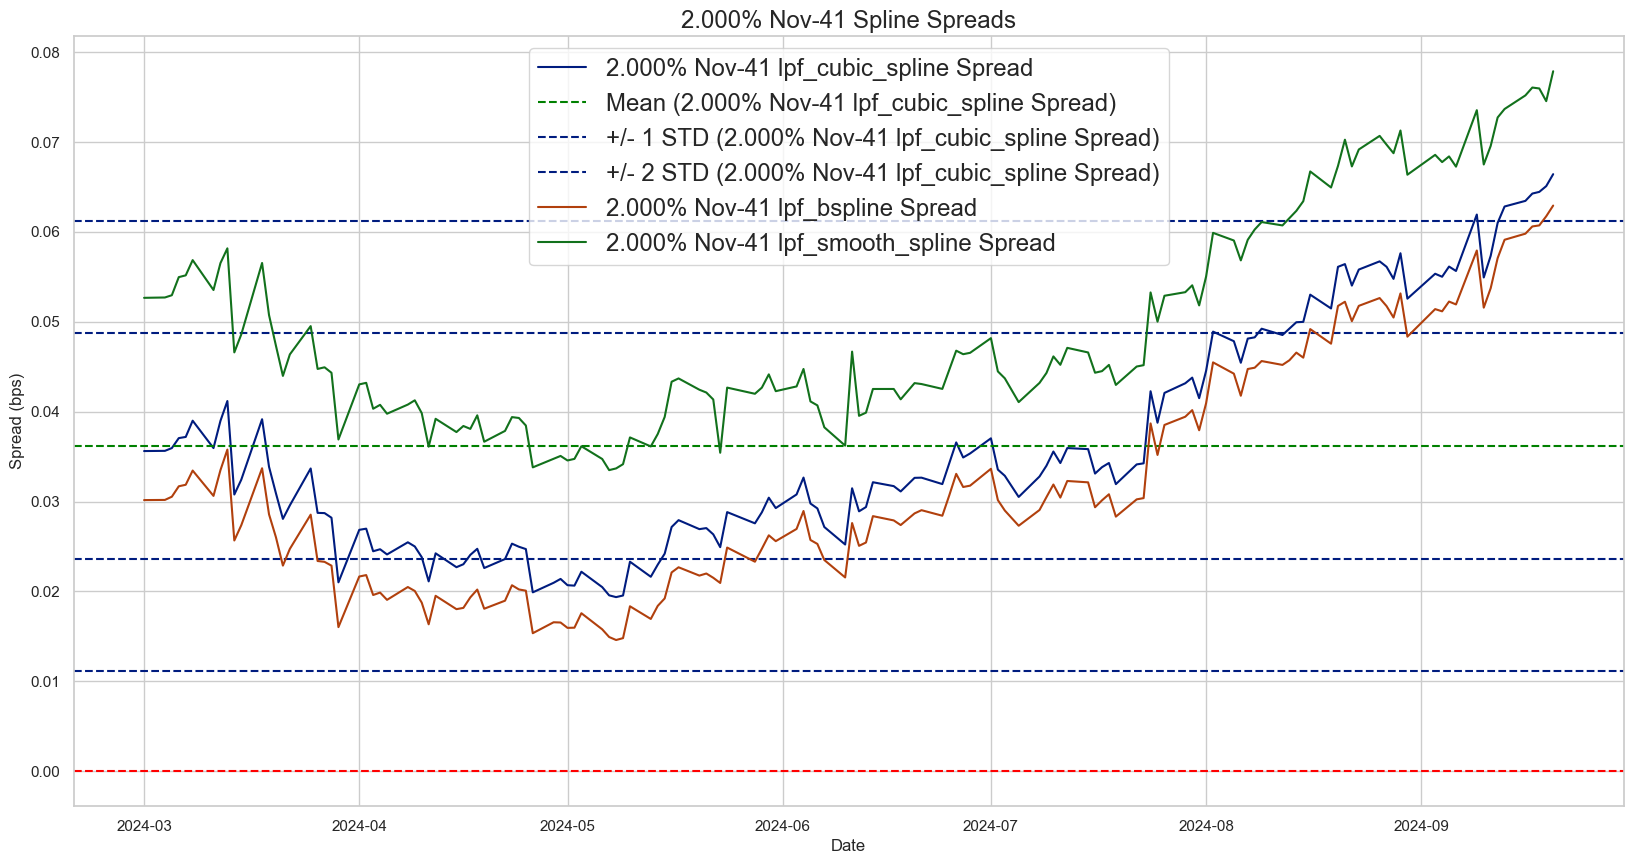

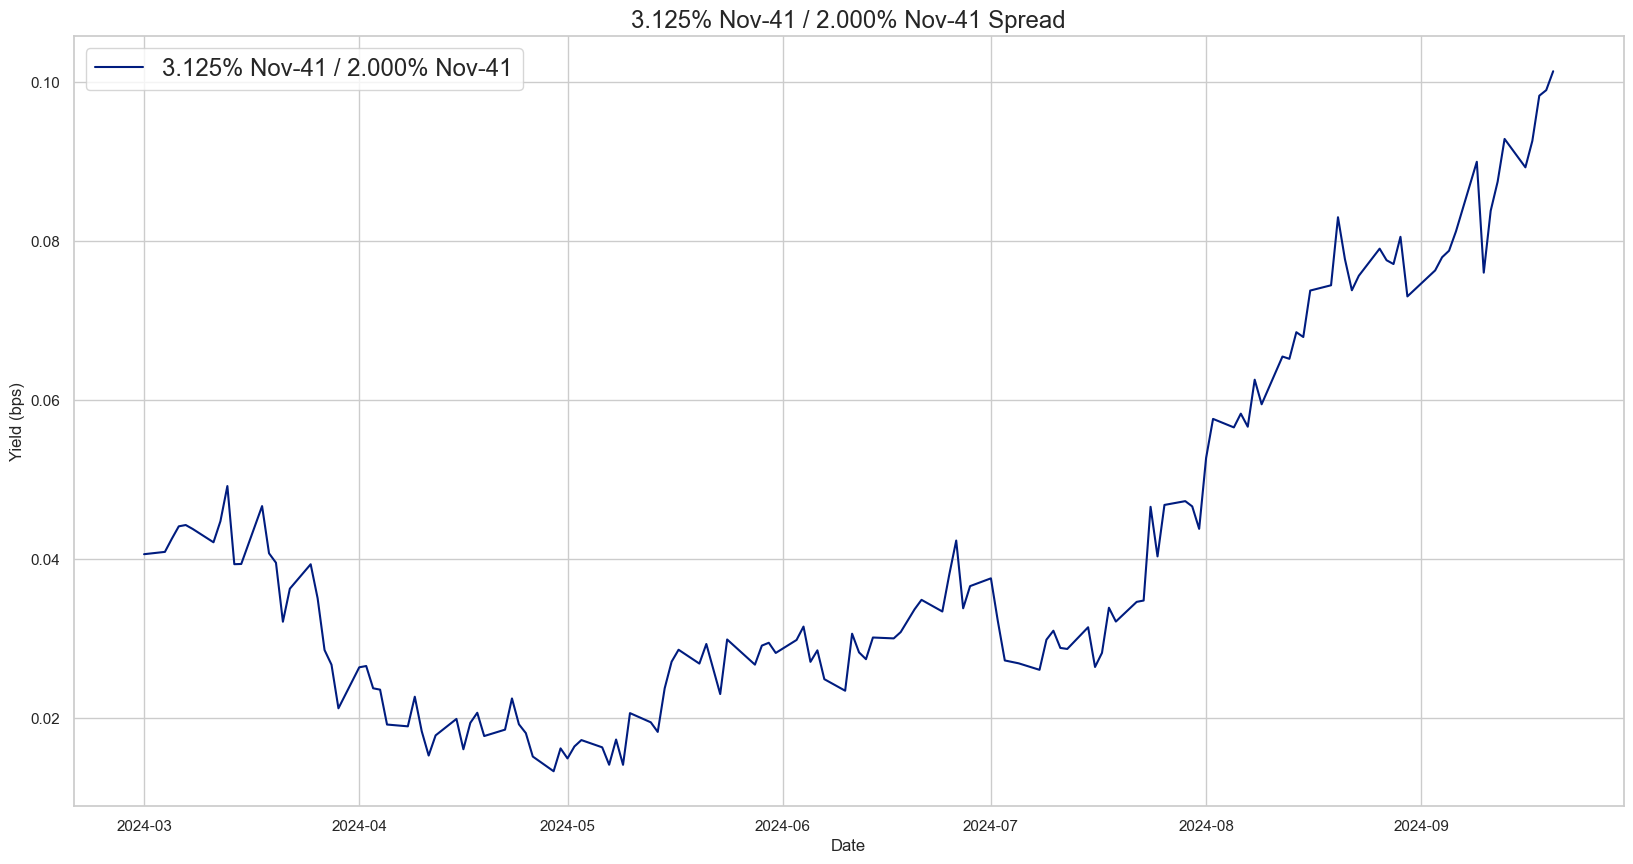

lpf_cubic_spline is Benchmark Spline


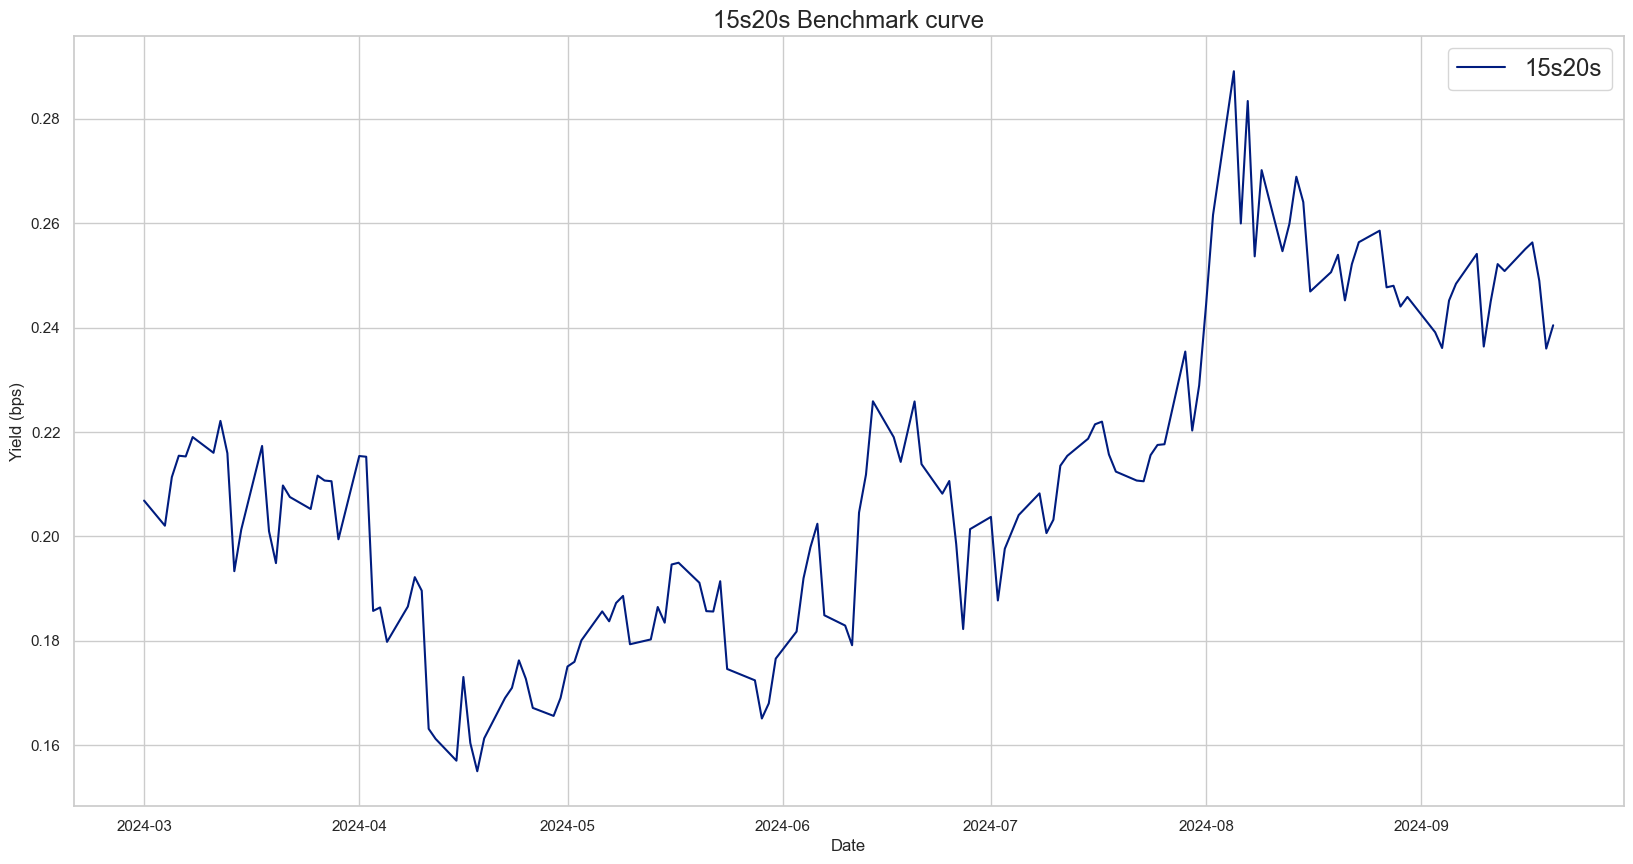

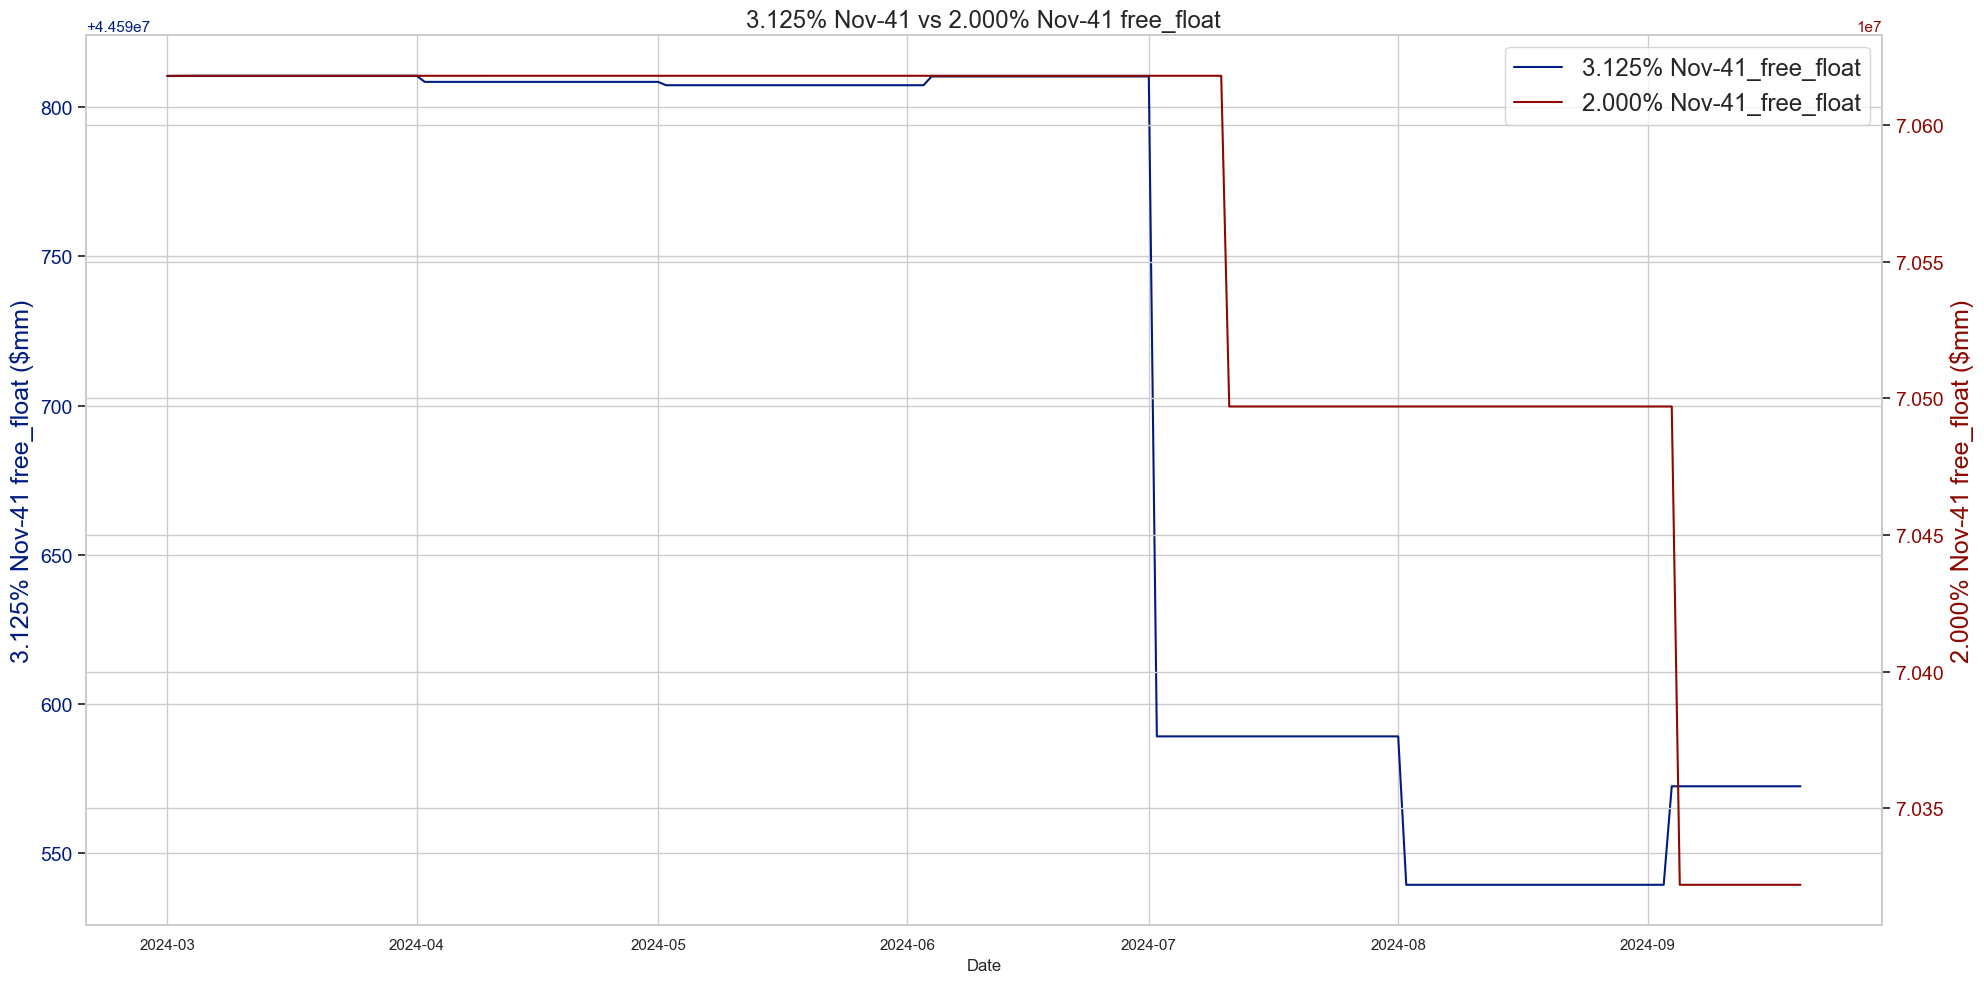

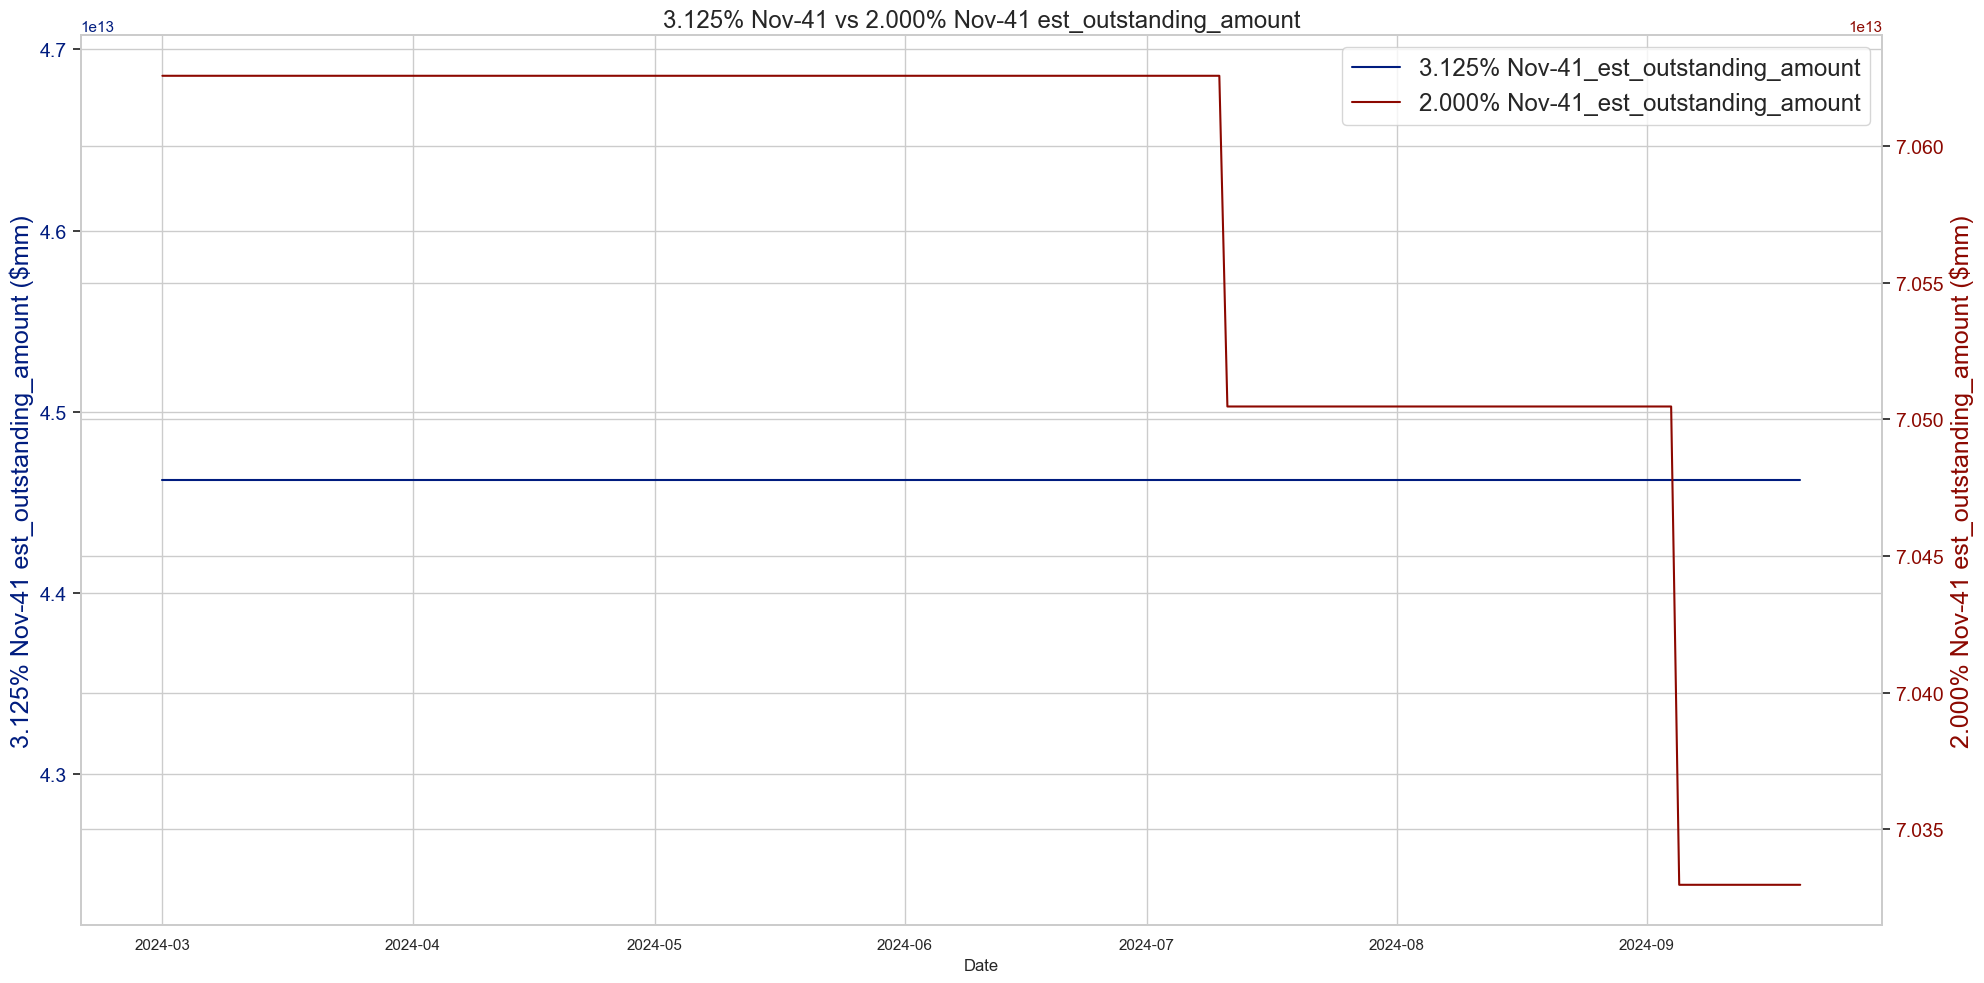

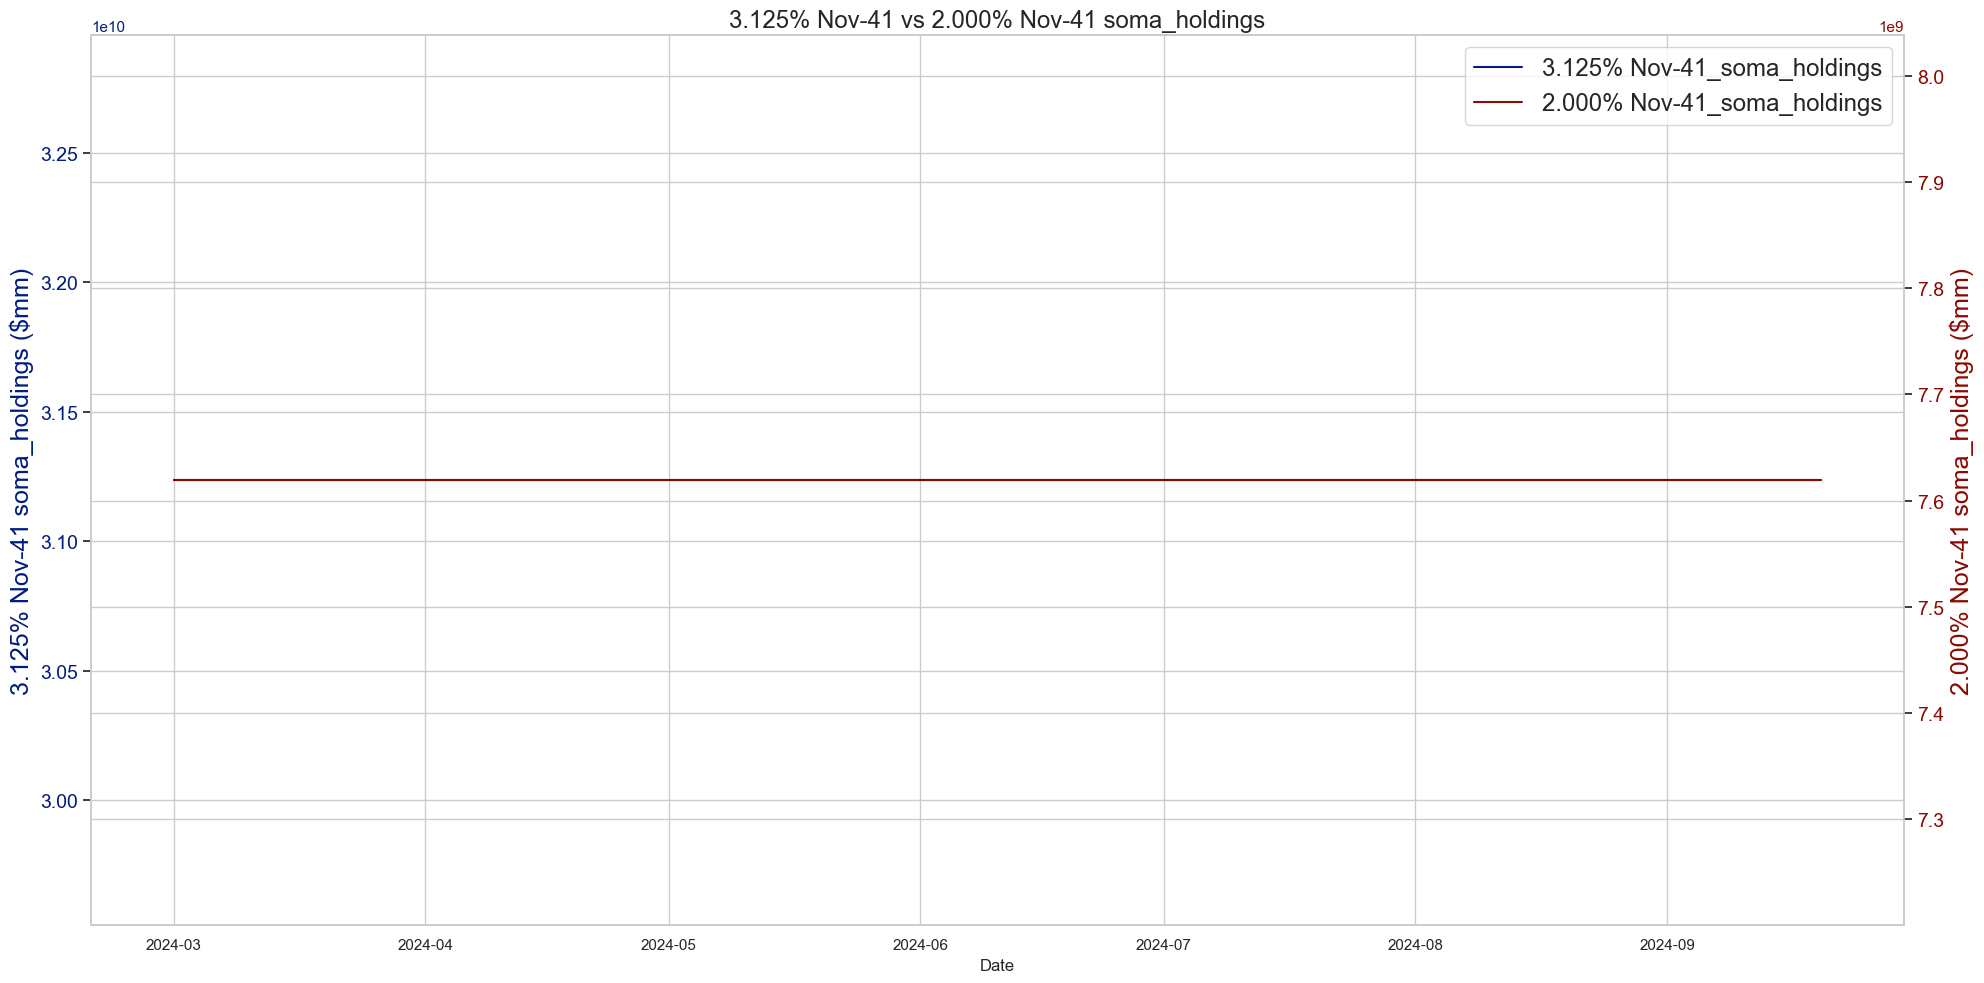

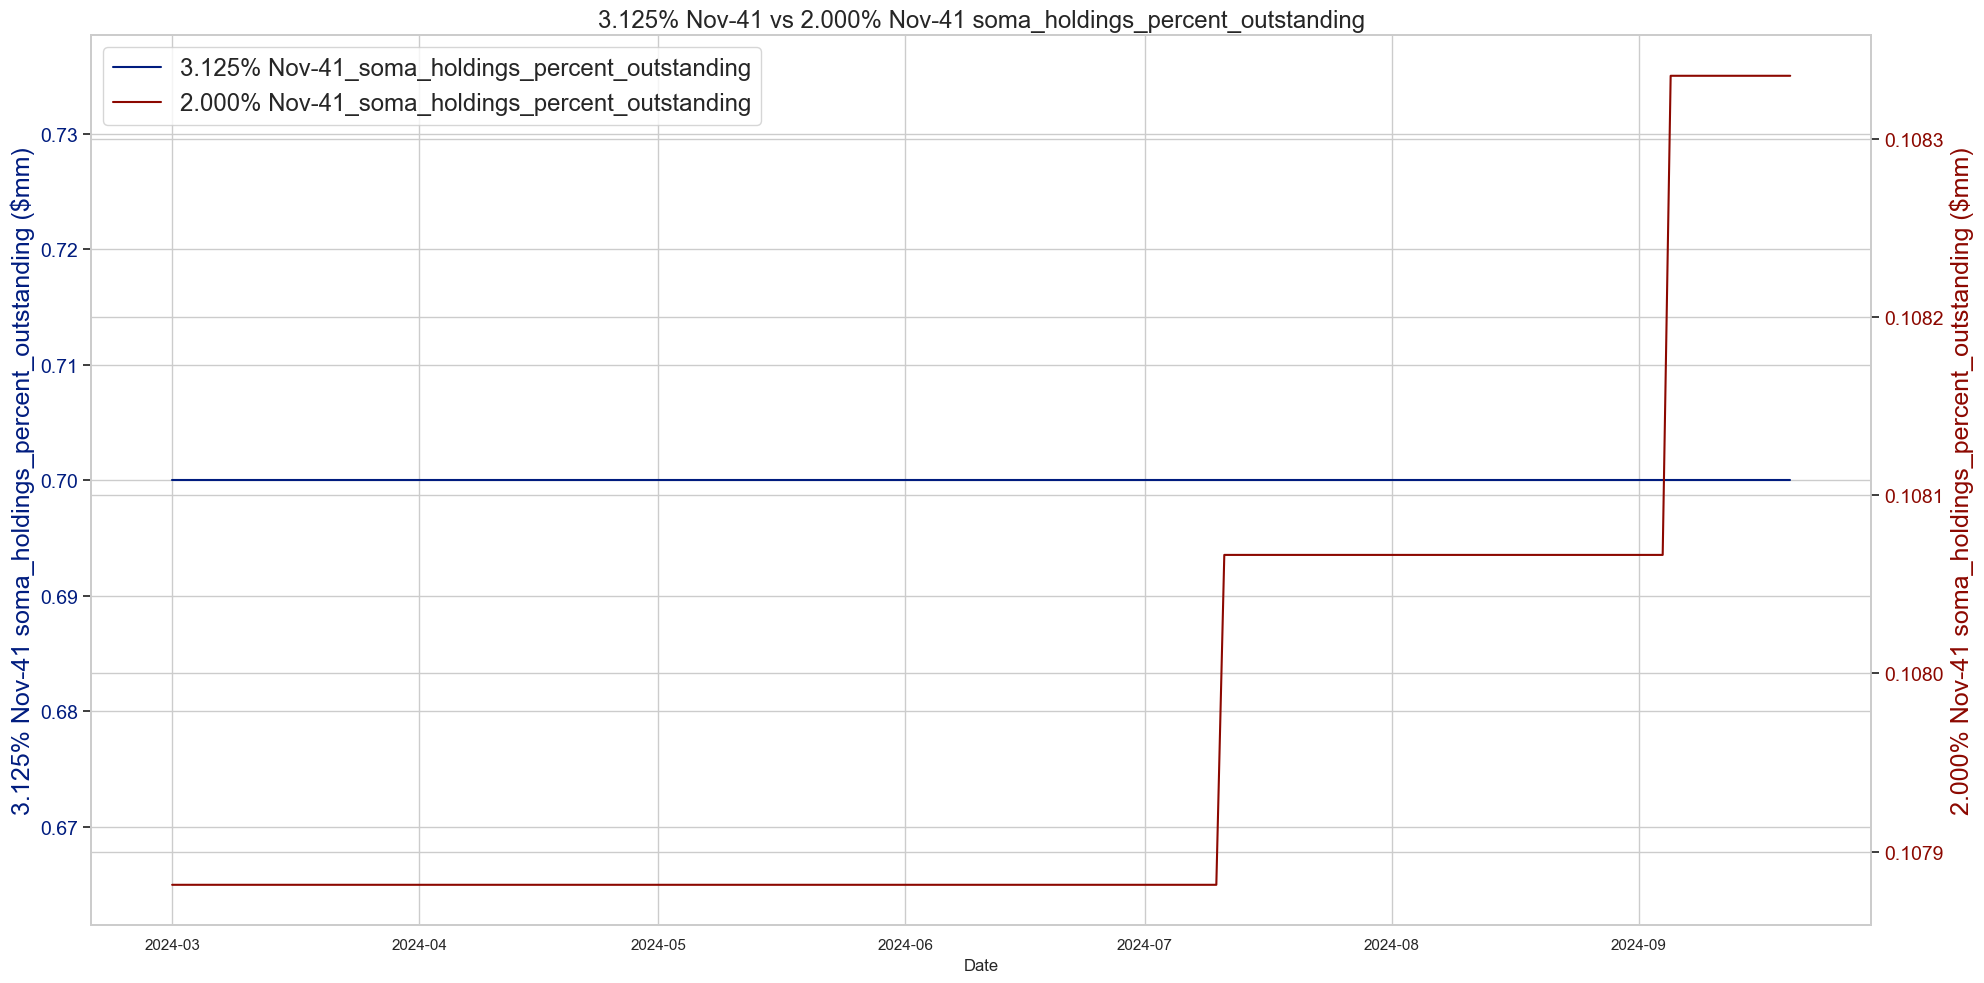

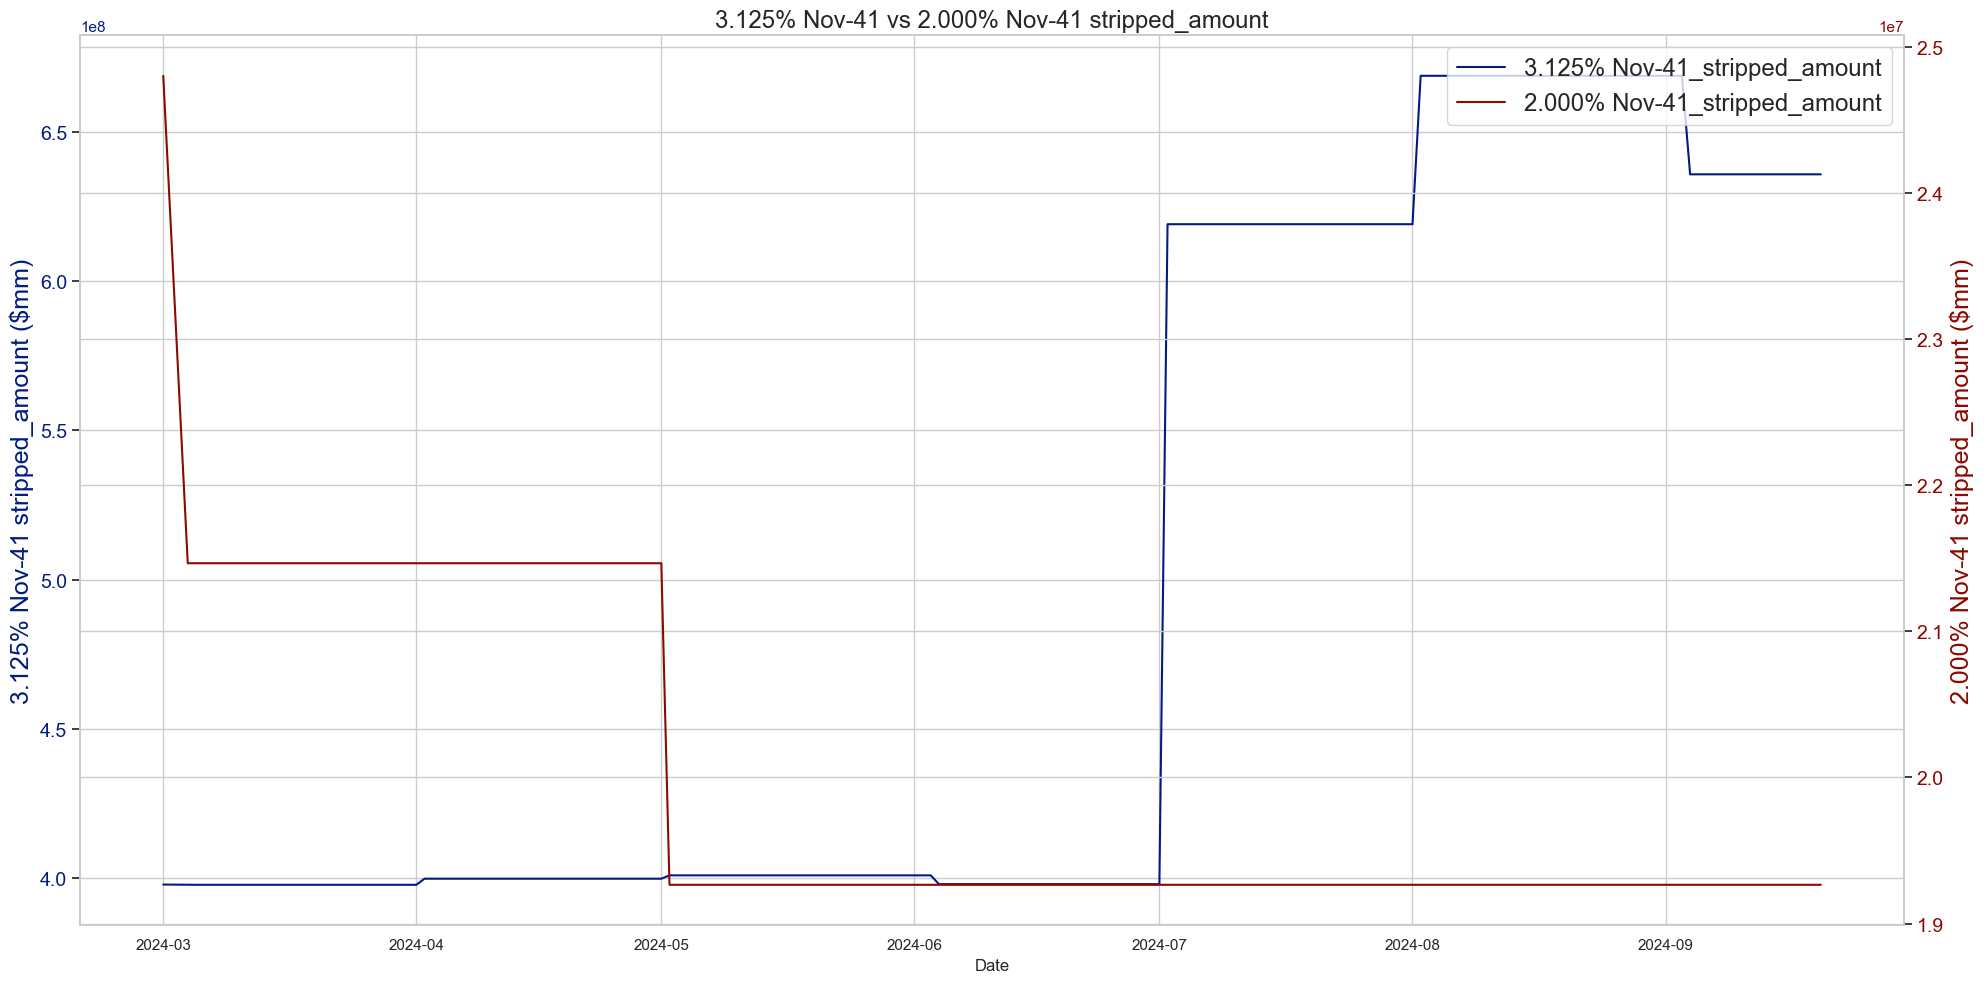

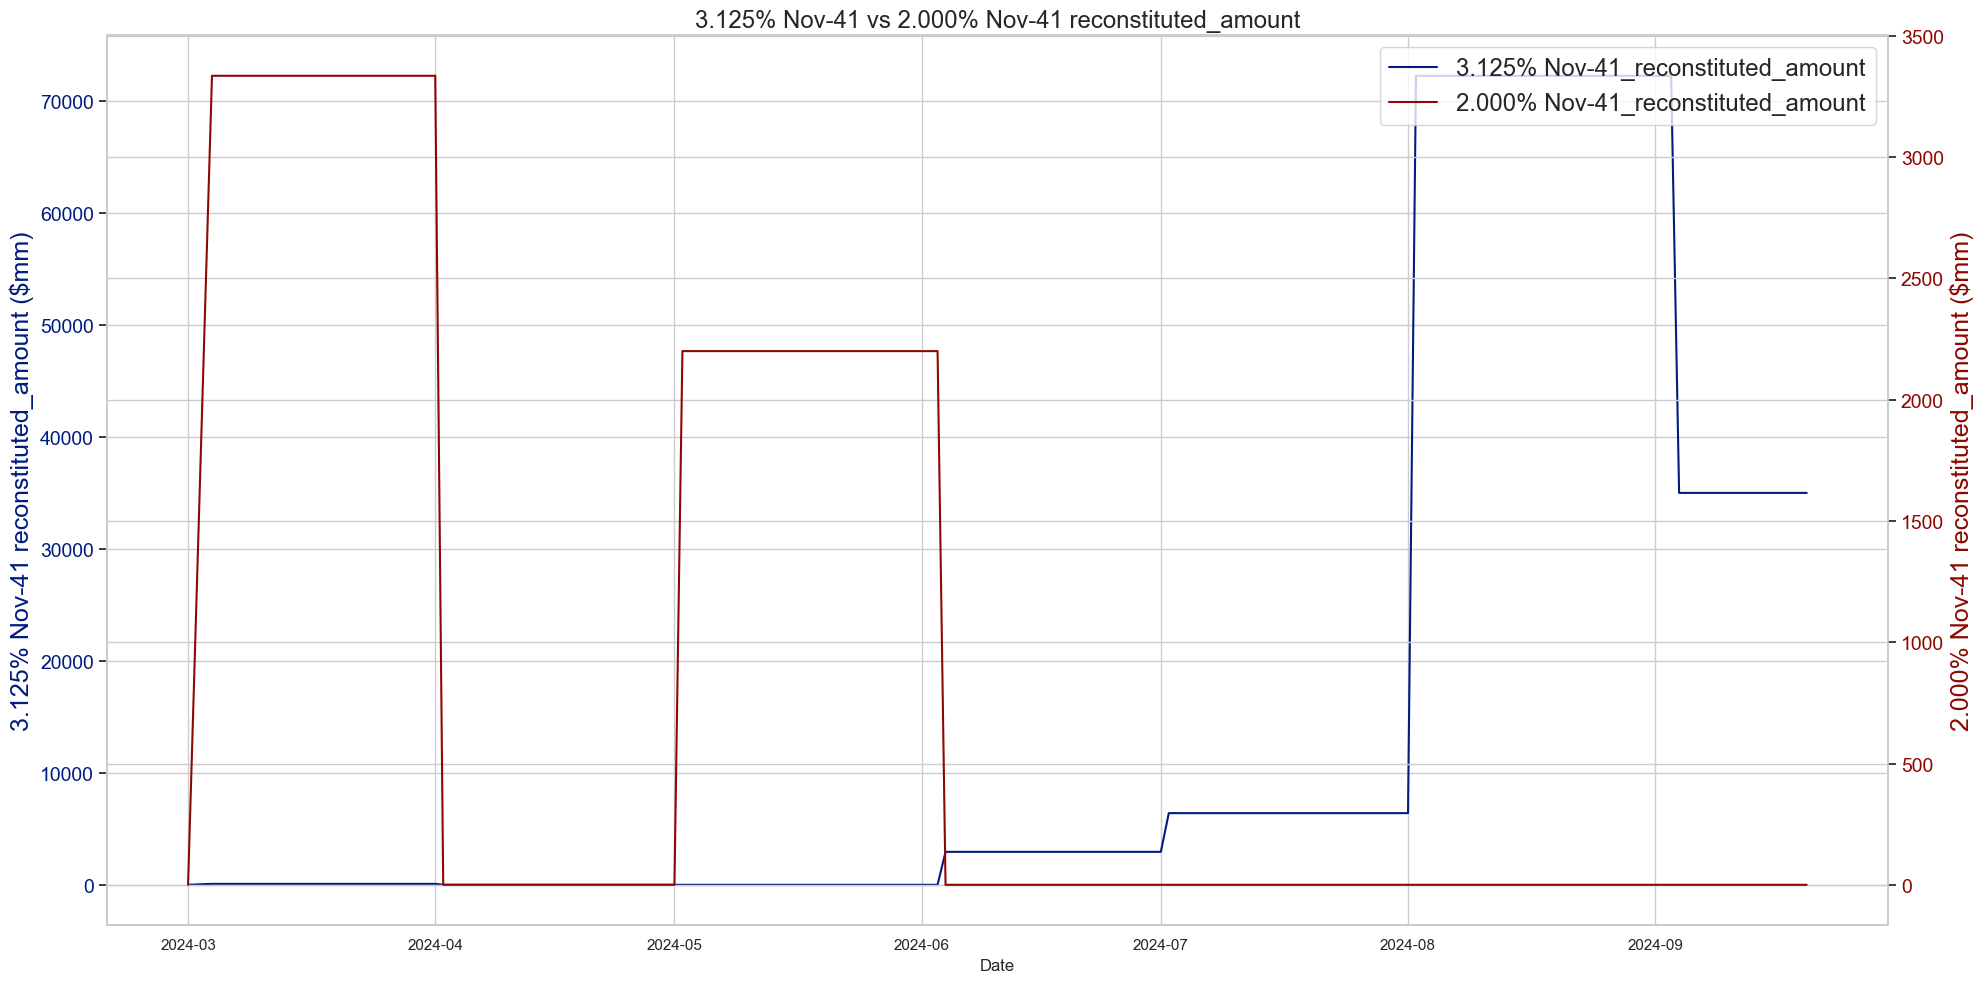

                                  OLS Regression Results                                 
Dep. Variable:     3.125% Nov-41 / 2.000% Nov-41   R-squared:                       0.702
Model:                                       OLS   Adj. R-squared:                  0.700
Method:                            Least Squares   F-statistic:                     330.3
Date:                           Thu, 05 Dec 2024   Prob (F-statistic):           1.16e-38
Time:                                   22:45:49   Log-Likelihood:                 421.28
No. Observations:                            142   AIC:                            -838.6
Df Residuals:                                140   BIC:                            -832.7
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
--------

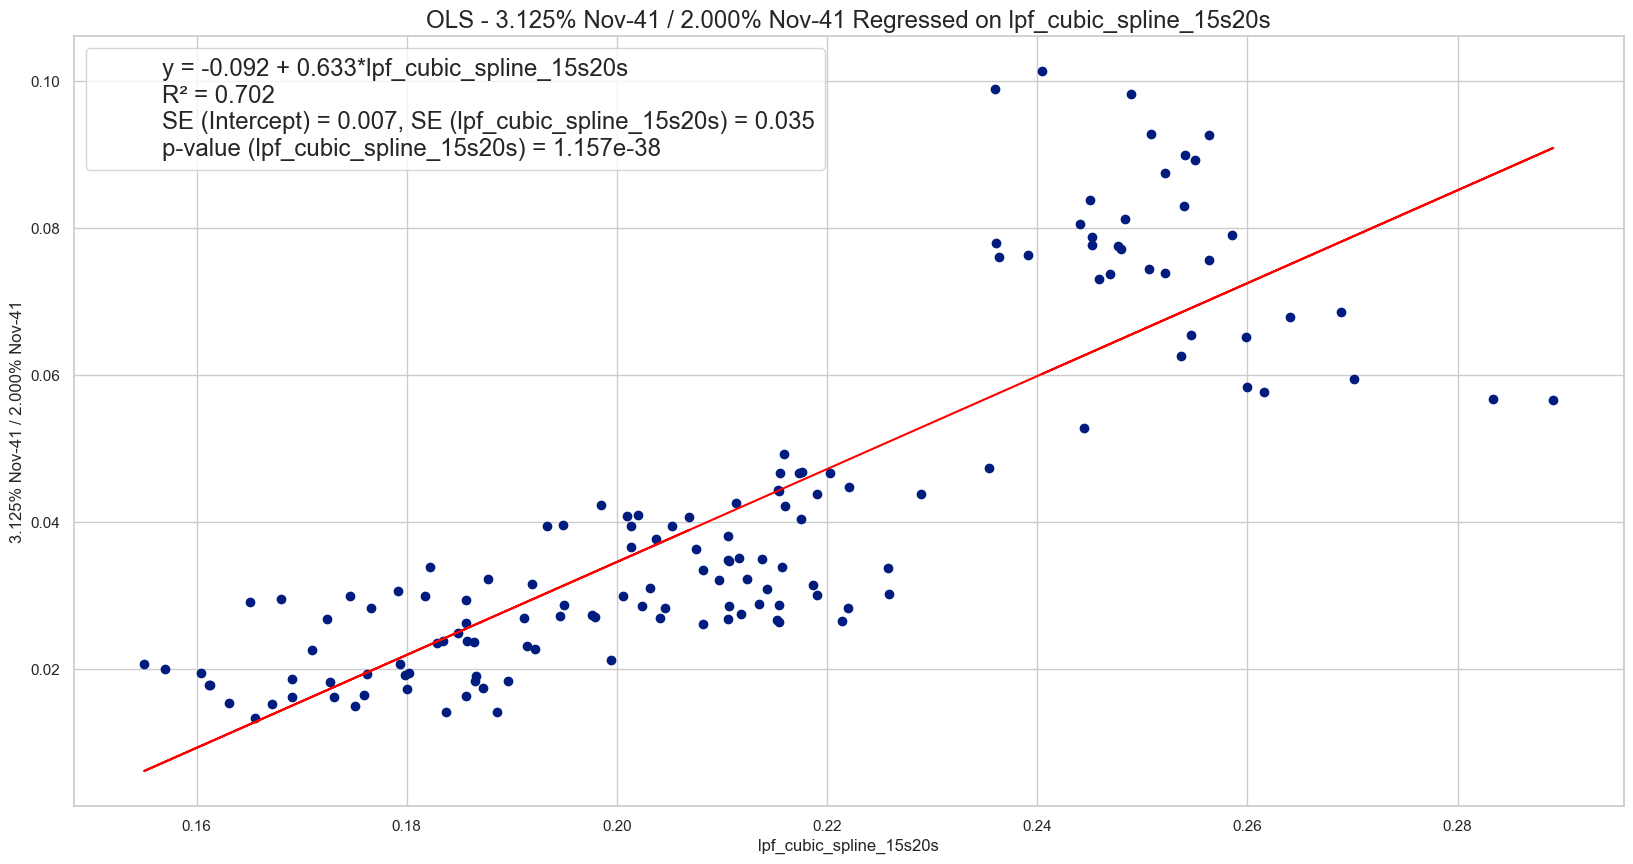

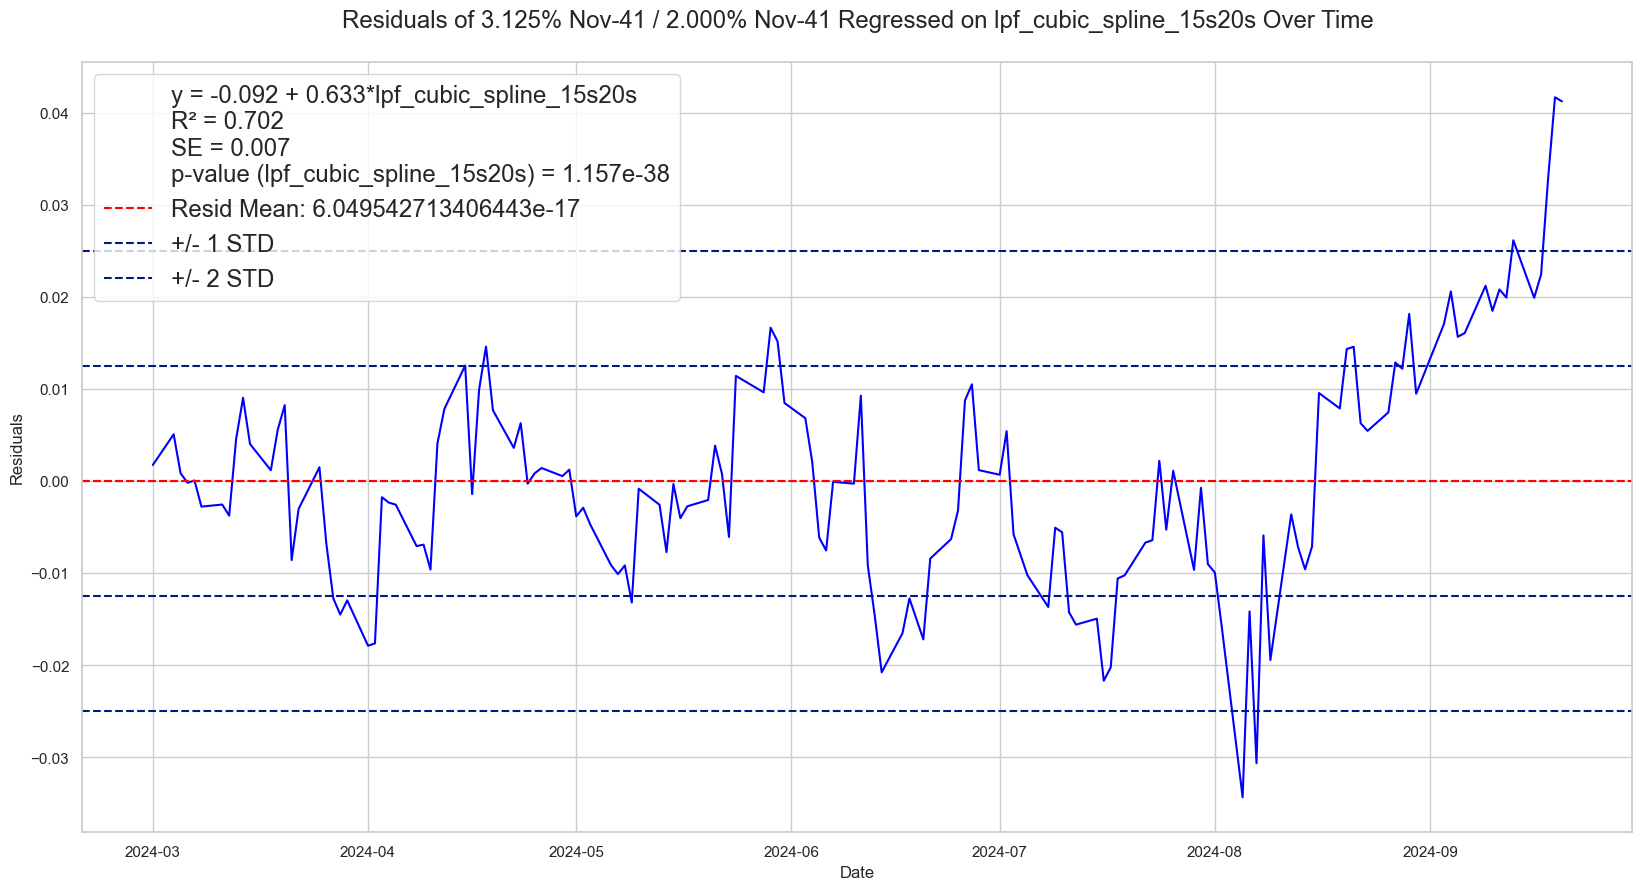

Using lpf_cubic_spline for UST Metrics Calcs


3.125% Nov-41 Metrics Calc: 142it [00:05, 27.64it/s]
2.000% Nov-41 Metrics Calc: 142it [00:04, 29.09it/s]


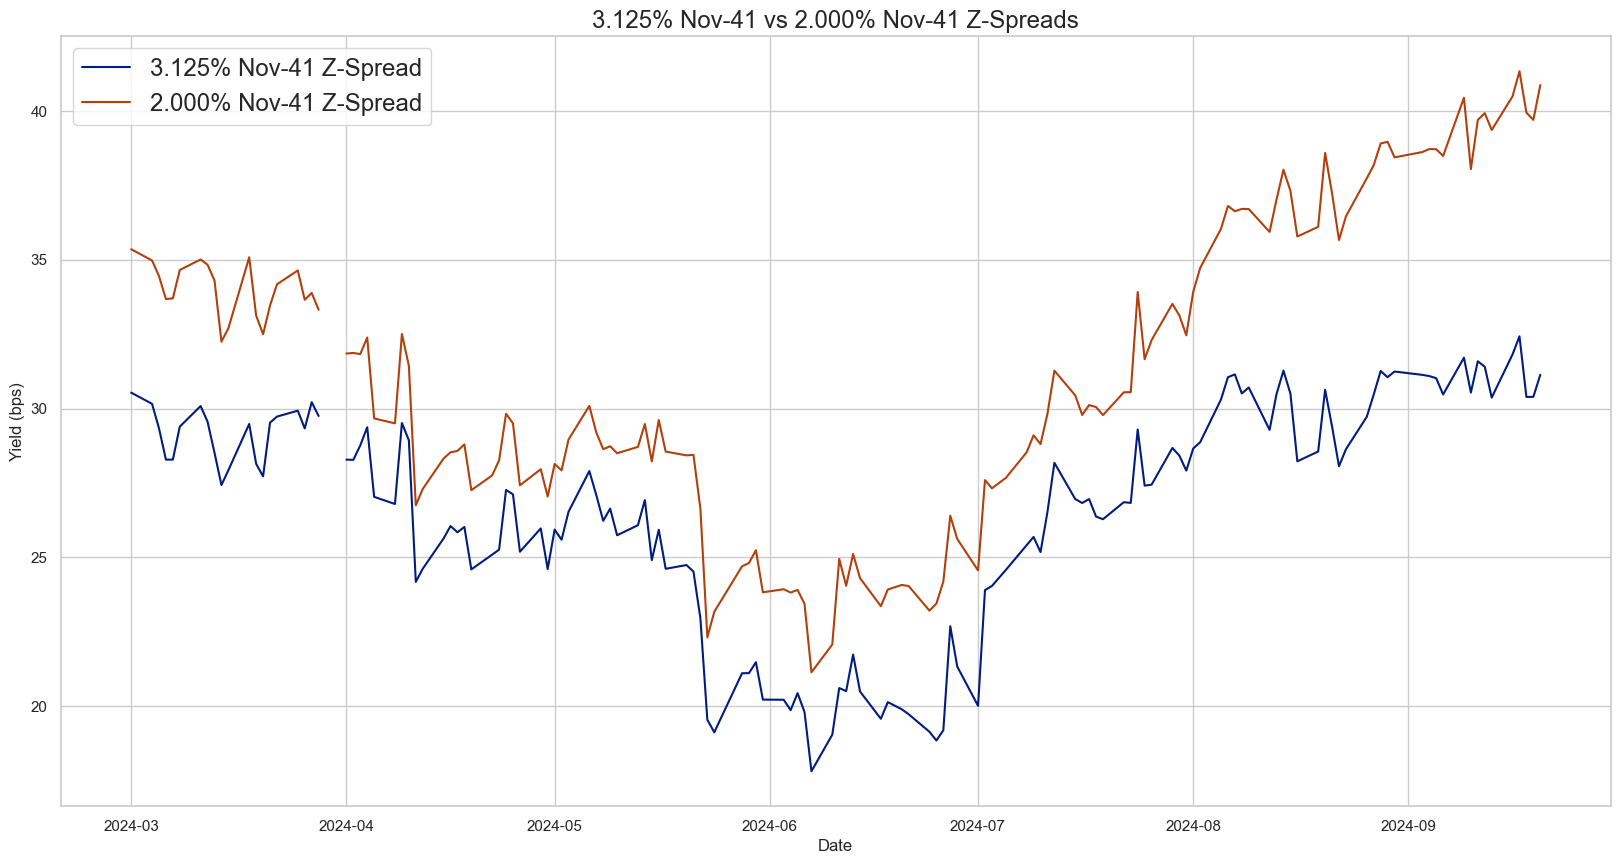

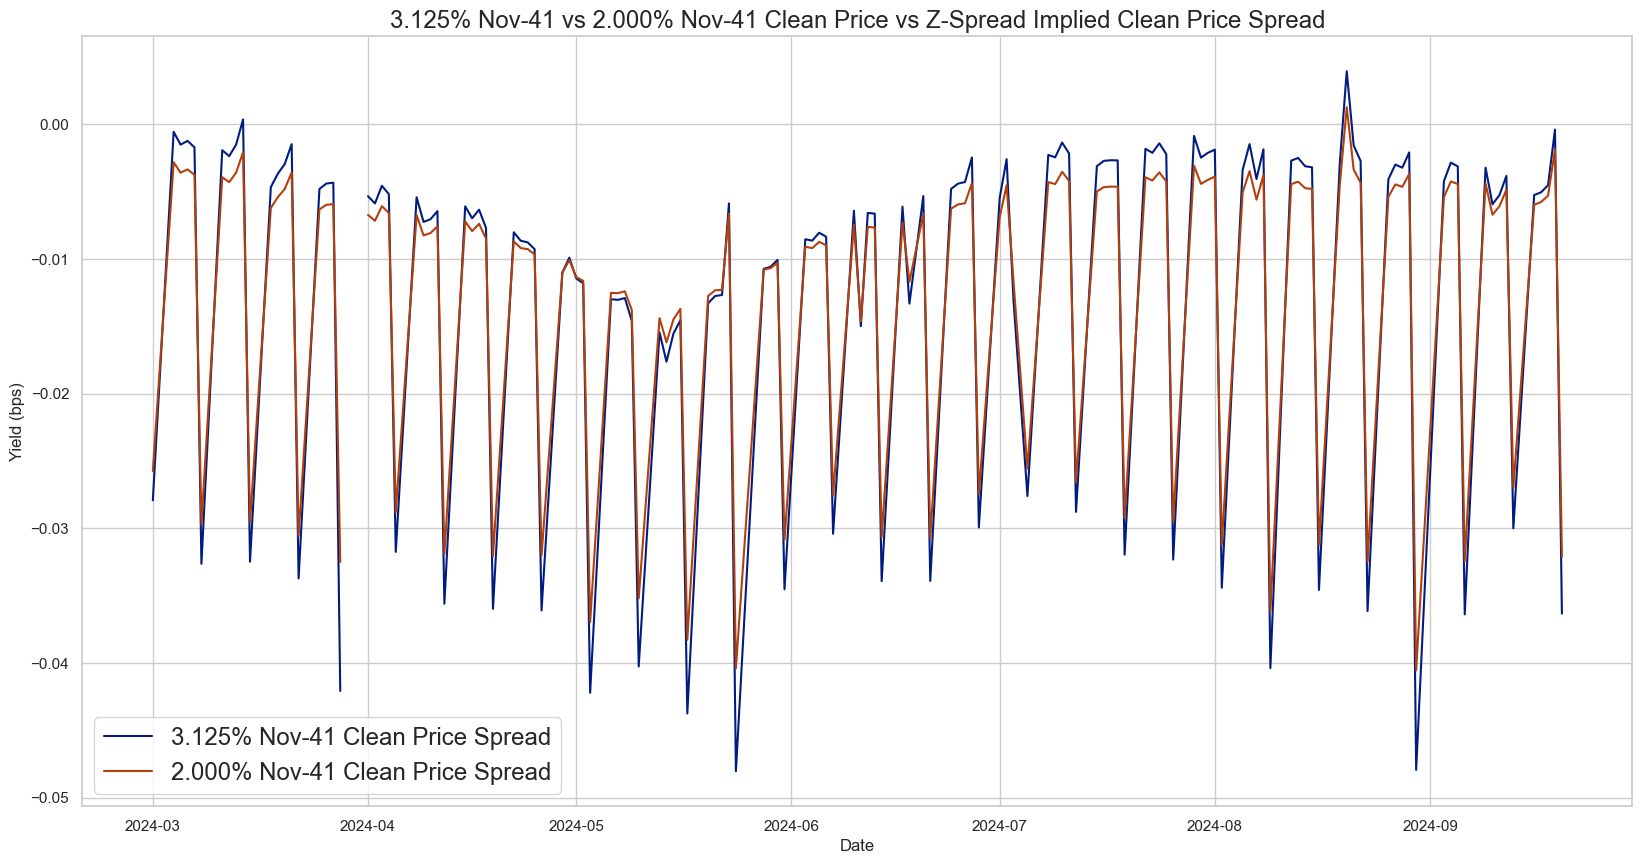

In [30]:
label1 = "3.125% Nov-41" 
label2 = "2.000% Nov-41" 

cusip_spread_rv_regression(
    usts_obj=usts,
    label1=label1,
    label2=label2,
    cusip_timeseries=cusip_timeseries,
    fitted_splines_timeseries_dict={
        "lpf_cubic_spline": fitted_cubic_spline_timeseries,
        "lpf_bspline": fitted_bspline_timeseries,
        "lpf_smooth_spline": fitted_smooth_spline_timeseries,
    },
    benchmark_tenor_1=15,
    benchmark_tenor_2=20,
    on_rate=5.33
)

## Hedge Ratios?

In [32]:
label1 = "3.125% Nov-41"
label2 = "2.000% Nov-41"

cusip1 = usts.ust_label_to_cusip(label1)["cusip"]
cusip2 = usts.ust_label_to_cusip(label2)["cusip"]

cusips_df = usts.get_ust_timeseries_by_cusips(
    cusips=[cusip1, cusip2], cusip_cols=["bid_yield", "offer_yield", "eod_yield"], start_date=start_date, end_date=end_date
)
cusips_df = cusips_df.rename(columns=lambda x: x.replace(cusip1, label1))
cusips_df = cusips_df.rename(columns=lambda x: x.replace(cusip2, label2))

cusips_df[f"{label1}-bid_offer_spread"] = cusips_df[f"{label1}-bid_yield"] - cusips_df[f"{label1}-offer_yield"] 
cusips_df[f"{label2}-bid_offer_spread"] = cusips_df[f"{label2}-bid_yield"] - cusips_df[f"{label2}-offer_yield"] 

cusips_df

,Date,3.125% Nov-41-bid_yield,3.125% Nov-41-offer_yield,3.125% Nov-41-eod_yield,2.000% Nov-41-bid_yield,2.000% Nov-41-offer_yield,2.000% Nov-41-eod_yield,3.125% Nov-41-bid_offer_spread,2.000% Nov-41-bid_offer_spread
0,2024-03-01,4.482022,4.476265,4.461896,4.525023,4.518596,4.502558,0.005757,0.006427
1,2024-03-04,4.499487,4.492271,4.490828,4.538222,4.531781,4.531781,0.007216,0.006442
2,2024-03-05,4.405048,4.396518,4.393678,4.445799,4.436285,4.436285,0.008529,0.009514
3,2024-03-06,4.376810,4.369733,4.351370,4.417613,4.409720,4.395538,0.007077,0.007893
4,2024-03-07,4.376958,4.369880,4.351515,4.417923,4.410029,4.395846,0.007078,0.007894
...,...,...,...,...,...,...,...,...,...
137,2024-09-16,3.990573,3.985149,3.985149,4.080541,4.074473,4.074473,0.005424,0.006068
138,2024-09-17,3.966305,3.960901,3.960901,4.059603,4.052044,4.053555,0.005404,0.007559
139,2024-09-18,3.917932,3.911228,3.931361,4.014654,4.007149,4.029692,0.006704,0.007505
140,2024-09-19,4.114229,4.107315,4.139185,4.213348,4.207147,4.238216,0.006915,0.006201


In [33]:
pca_results = calc_pca_loadings_matrix(df=cusips_df, cols=[f"{label1}-eod_yield", f"{label2}-eod_yield"], run_on_level_changes=True, scale_loadings=True)
pca_results

{'pca': PCA(),
 'loading_matrix':                               PC1       PC2
 3.125% Nov-41-eod_yield  0.081916 -0.001958
 2.000% Nov-41-eod_yield  0.080990  0.001980,
 'pc_scores_matrix':      Date       PC1       PC2   PC3
 0       1  0.045429 -0.000159  None
 1       2 -0.131917 -0.000116  None
 2       3 -0.054425 -0.000490  None
 3       4  0.004628  0.000163  None
 4       5 -0.007385  0.000694  None
 ..    ...       ...       ...   ...
 136   137  0.101070  0.002256  None
 137   138 -0.027641 -0.001892  None
 138   139 -0.033475 -0.003519  None
 139   140  0.298703 -0.001888  None
 140   141 -0.187887 -0.000310  None
 
 [141 rows x 4 columns],
 'covar_matrix':                          3.125% Nov-41-eod_yield  2.000% Nov-41-eod_yield
 3.125% Nov-41-eod_yield                 0.006714                 0.006631
 2.000% Nov-41-eod_yield                 0.006631                 0.006563}

In [34]:
curve_beta_ests = beta_estimates(
    df=cusips_df,
    x_cols=[f"{label1}-eod_yield"],
    y_col=f"{label2}-eod_yield",
    run_on_level_changes=True,
    x_errs=cusips_df[f"{label1}-bid_offer_spread"].to_numpy(),
    y_errs=cusips_df[f"{label2}-bid_offer_spread"].to_numpy(),
    loadings_df=pca_results["loading_matrix"]
)

curve_beta_ests["betas"]

c:\Users\chris\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



{'ols': np.float64(0.9875573309790282),
 'tls': np.float64(0.9886991463901743),
 'odr': np.float64(nan),
 'pc1': np.float64(0.9886991446180502),
 'box_tiao': [np.float64(0.9025332360050223)],
 'johansen': [0.8989648083252657],
 'minimum_half_life': [np.float64(0.9034816048519972)],
 'adf_optimal': [np.float64(185.34865763531639)]}

In [37]:
label1_row = curve_set_df[curve_set_df["ust_label"] == label1]
label2_row = curve_set_df[curve_set_df["ust_label"] == label2]

dv01_neutral_curve_hegde_ratio(
    as_of_date=as_of_date,
    front_leg_bond_row=label1_row,
    back_leg_bond_row=label2_row,
    usts_obj=usts,
    scipy_interp_curve=fitted_bspline,
    repo_rate=5.33,
    yvx_beta_adjustment=curve_beta_ests["betas"]["box_tiao"][0],
    front_leg_par_amount=20_000_000
)

3.125% Nov-41 / 2.000% Nov-41
BPV Neutral Hedge Ratio: 0.8923031735558787
Beta Weighted Hedge Ratio: 0.805333
Front Leg: 3.125% Nov-41 (OST 30-Year, TTM = 17.164384) Par Amount = 20_000_000
Back Leg: 2.000% Nov-41 (OST 20-Year, TTM = 17.164384) Par Amount = 24_834_439.016715273
Total Trade Par Amount: 44_834_439.01671527
Risk Weights: 0.902533 : 100


{'current_spread': 10.141046047350244,
 'current_bpv_neutral_spread': 53.24235320635351,
 'current_beta_weighted_spread': np.float64(88.0485459158829),
 'rough_3m_impl_fwd_spread': np.float64(0.0),
 'rough_6m_impl_fwd_spread': np.float64(0.0),
 'rough_12m_impl_fwd_spread': np.float64(0.0),
 'front_leg_metrics': {'Date': datetime.datetime(2024, 9, 20, 0, 0),
  'zspread': 30.466582269752642,
  'zspread_impl_clean_price': 89.23773521217157,
  'clean_price': 89.19727429743912,
  'dirty_price': 92.83742851638137,
  'accrued_amount': 0.00853825136613029,
  'bps': -0.1148537482577768,
  'dv01_1mm': -1148.537482577768,
  'mac_duration': 13.135450195057084,
  'mod_duration': 12.877760015925245,
  'convexity': 202.3557926678178,
  'basis_point_value': -0.1148537482577768,
  'yield_value_basis_point': -8.706656567514975e-06,
  'rough_carry': -1.3279036911206985,
  'rough_3m_rolldown': np.float64(2.4668292343761777),
  'rough_6m_rolldown': np.float64(2.3604057372096143),
  'rough_12m_rolldown': np